In [1]:
# import libraries

In [4]:
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random as rn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , roc_curve , auc
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten, Dense, Activation,BatchNormalization
from tensorflow.keras.applications import inception_v3 
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D,MaxPooling2D, Dropout,Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16

ModuleNotFoundError: No module named 'pandas'

In [3]:
# Read data and make data pickle

In [4]:
data_dir = "D:\MACHINE LEARNING\Projects\Breast Cancer Detection\Dataset"

In [5]:
categories = ["Normal","Abnormal"]

In [6]:
data = []
def make_data():
    for category in categories:
        path = os.path.join(data_dir,category)
        label = categories.index(category)
        print(category + "--" + str(label))
        for img_name in os.listdir(path):
            img_path = os.path.join(path,img_name)
            image = cv2.imread(img_path)
            try:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,(224,224))
                image = np.array(image,dtype=np.float32)
                data.append([image,label])
            except Exception as e:
                pass
    print(len(data))
    pik = open("model/data.pickle","wb")
    pickle.dump(data,pik)
    pik.close()
make_data()

Normal--0
Abnormal--1
74


In [24]:
def load_data():
    pick  = open("model/data.pickle","rb")
    data = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(data)
    feature = []
    labels = []
    
    for img , label in data:
        feature.append(img)
        labels.append(label)
    
    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)

    feature = feature/255.0

    return [feature, labels]
    

In [25]:
feature,labels = load_data()

In [26]:
labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1])

In [27]:
print(feature.shape)

(74, 224, 224, 3)


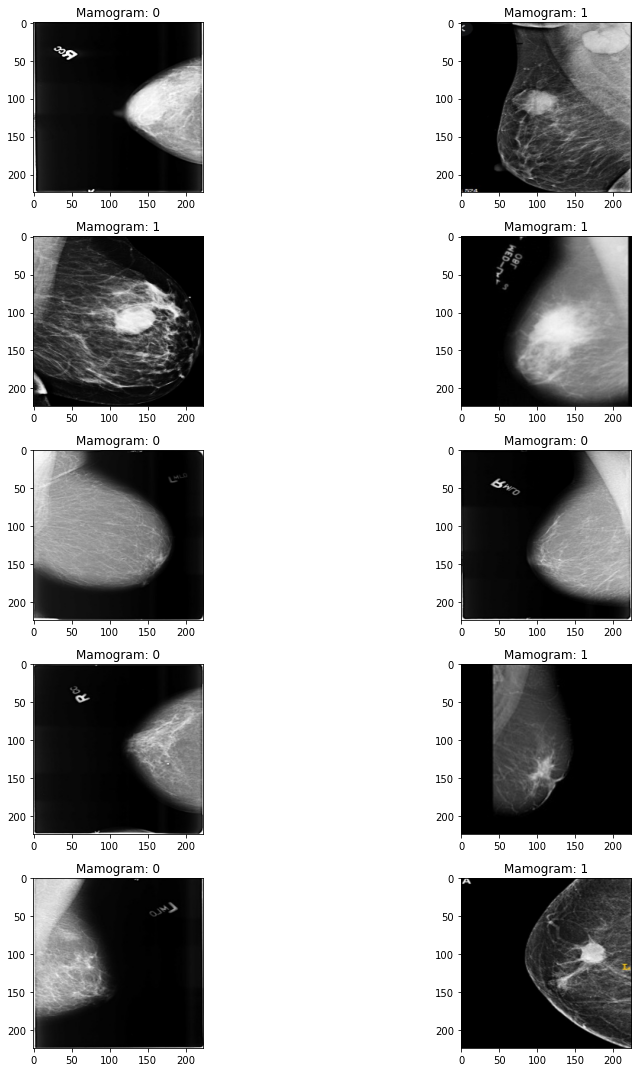

In [28]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(feature[l])
        ax[i,j].set_title('Mamogram: '+str(labels[l]))
        
plt.tight_layout()

In [29]:
## splits for train and test and set random seed and data genaration

In [30]:
x_train,x_test,y_train,y_test = train_test_split(feature,labels,test_size = 0.25,random_state = 42)

In [31]:
datagen_train = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen_train.fit(x_train)

datagen_test = ImageDataGenerator(
        rescale = 1./255
)

datagen_test.fit(x_test)

In [32]:
# x_train
# x_test
# y_train
# y_test

In [33]:
tf.random.set_seed(
  np.random.seed(42)
)

In [34]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (5,5), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Prediction')

In [35]:
## CNN MODEL

In [41]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='sigmoid'))

    model.add(Flatten())

    return model

In [42]:
batch_size=9
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [43]:
model = create_model()

model.compile(loss='binary_crossentropy',
             optimizer='RMSProp',
             metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)       

In [45]:
History = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/100
7/7 [==============================] - 5s 553ms/step - loss: 0.7637 - accuracy: 0.0000e+00 - val_loss: 0.6983 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 3s 482ms/step - loss: 0.6371 - accuracy: 0.0000e+00 - val_loss: 0.6971 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 4s 579ms/step - loss: 0.5377 - accuracy: 0.0000e+00 - val_loss: 0.7063 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 4s 613ms/step - loss: 0.5593 - accuracy: 0.0000e+00 - val_loss: 0.7118 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 4s 612ms/step - loss: 0.4989 - accuracy: 0.0000e+00 - val_loss: 0.7517 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 4s 613ms/step - loss: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.7703 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 4s 629ms/step - loss: 0.5724 - accuracy: 0.0000e+00 - v

Epoch 56/100
7/7 [==============================] - 5s 658ms/step - loss: 0.3016 - accuracy: 0.0000e+00 - val_loss: 1.5998 - val_accuracy: 0.0000e+00
Epoch 57/100
7/7 [==============================] - 5s 665ms/step - loss: 0.3060 - accuracy: 0.0000e+00 - val_loss: 1.8564 - val_accuracy: 0.0000e+00
Epoch 58/100
7/7 [==============================] - 5s 659ms/step - loss: 0.3941 - accuracy: 0.0000e+00 - val_loss: 1.2065 - val_accuracy: 0.0000e+00
Epoch 59/100
7/7 [==============================] - 5s 646ms/step - loss: 0.2333 - accuracy: 0.0000e+00 - val_loss: 1.5478 - val_accuracy: 0.0000e+00
Epoch 60/100
7/7 [==============================] - 4s 634ms/step - loss: 0.2597 - accuracy: 0.0000e+00 - val_loss: 1.2884 - val_accuracy: 0.0000e+00
Epoch 61/100
7/7 [==============================] - 4s 626ms/step - loss: 0.2602 - accuracy: 0.0000e+00 - val_loss: 1.5702 - val_accuracy: 0.0000e+00
Epoch 62/100
7/7 [==============================] - 5s 645ms/step - loss: 0.3058 - accuracy: 0.0000e

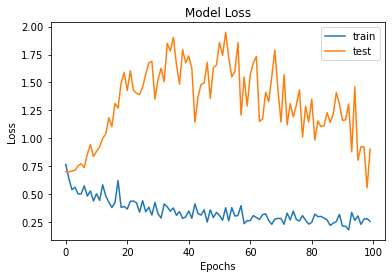

In [46]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

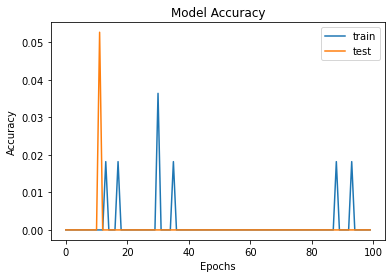

In [49]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [50]:
pred=model.predict(x_test)
pred_digits=np.argmax(np.round(abs(pred)).astype(int))

print(pred_digits)

0


In [51]:
model.save("model/BCDCNN.h5")

In [52]:
_, acc = model.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 216ms/step - loss: 0.9014 - accuracy: 0.0000e+00
Accuracy =  0.0 %


In [53]:
## resnet50 MODEL

In [54]:
def create_model1():
    base_model=resnet50.ResNet50(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)
    model1=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model1

In [55]:
batch_size=9
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr1= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [56]:
model1 = create_model1()

model1.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [57]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [58]:
History1 = model1.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/100
7/7 [==============================] - 9s 835ms/step - loss: 0.7592 - accuracy: 0.5091 - val_loss: 0.6869 - val_accuracy: 0.5263
Epoch 2/100
7/7 [==============================] - 6s 938ms/step - loss: 0.6978 - accuracy: 0.4727 - val_loss: 0.7288 - val_accuracy: 0.4737
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 0.7121 - accuracy: 0.5636 - val_loss: 0.7522 - val_accuracy: 0.4737
Epoch 4/100
7/7 [==============================] - 7s 971ms/step - loss: 0.6915 - accuracy: 0.5636 - val_loss: 0.6832 - val_accuracy: 0.6316
Epoch 5/100
7/7 [==============================] - 6s 924ms/step - loss: 0.6793 - accuracy: 0.6182 - val_loss: 0.6788 - val_accuracy: 0.5263
Epoch 6/100
7/7 [==============================] - 6s 921ms/step - loss: 0.6882 - accuracy: 0.5455 - val_loss: 0.6790 - val_accuracy: 0.5263
Epoch 7/100
7/7 [==============================] - 6s 913ms/step - loss: 0.6903 - accuracy: 0.4364 - val_loss: 0.7276 - val_accuracy: 0.4737
Epoch 8/100
7/7 

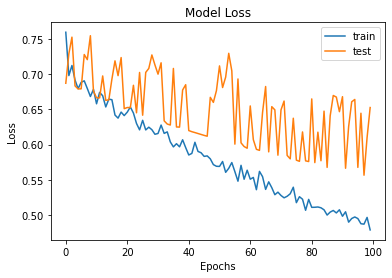

In [59]:
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

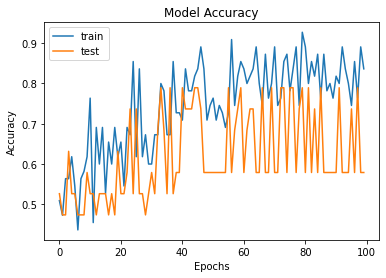

In [60]:
plt.plot(History1.history['accuracy'])
plt.plot(History1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [61]:
pred1=model1.predict(x_test)
pred_digits1=np.round(abs(pred1)).astype(int)
print(pred_digits1)

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [64]:
model1.save("model/BCDRESNET50.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [65]:
_, acc1 = model1.evaluate(x_test, y_test)
print("Accuracy = ", (acc1 * 100.0), "%")

1/1 [==============================] - 1s 1s/step - loss: 0.6525 - accuracy: 0.5789
Accuracy =  57.894736528396606 %


In [66]:
print(classification_report(y_test,pred_digits1))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       1.00      0.20      0.33        10

    accuracy                           0.58        19
   macro avg       0.76      0.60      0.51        19
weighted avg       0.78      0.58      0.50        19



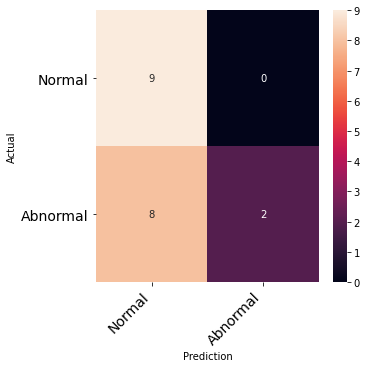

In [67]:
cm = confusion_matrix(y_test,pred_digits1)
print_confusion_matrix(cm,["Normal","Abnormal"])

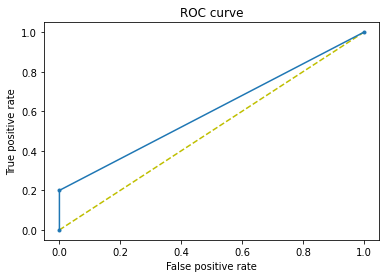

In [68]:
roc1 = pred_digits1.ravel()
fpr, tpr, thresholds = roc_curve(y_test, roc1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [69]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [70]:
auc_value1 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value1)

Area under curve, AUC =  0.6


In [71]:
## VGG16

In [72]:
def create_model2():
    base_model=vgg16.VGG16(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)
    model2=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model2

In [74]:
batch_size=9
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr2= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [75]:
model2 = create_model2()

model2.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [76]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [77]:
History2 = model2.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/100
7/7 [==============================] - 12s 2s/step - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.6616 - val_accuracy: 0.5263
Epoch 2/100
7/7 [==============================] - 19s 3s/step - loss: 0.6609 - accuracy: 0.7273 - val_loss: 0.6600 - val_accuracy: 0.5789
Epoch 3/100
7/7 [==============================] - 18s 3s/step - loss: 0.6402 - accuracy: 0.6727 - val_loss: 0.6479 - val_accuracy: 0.8421
Epoch 4/100
7/7 [==============================] - 18s 3s/step - loss: 0.6293 - accuracy: 0.7818 - val_loss: 0.6461 - val_accuracy: 0.6316
Epoch 5/100
7/7 [==============================] - 17s 2s/step - loss: 0.6122 - accuracy: 0.7455 - val_loss: 0.6344 - val_accuracy: 0.7895
Epoch 6/100
7/7 [==============================] - 16s 2s/step - loss: 0.6031 - accuracy: 0.8727 - val_loss: 0.6253 - val_accuracy: 0.7895
Epoch 7/100
7/7 [==============================] - 16s 2s/step - loss: 0.5955 - accuracy: 0.9091 - val_loss: 0.6248 - val_accuracy: 0.7895
Epoch 8/100
7/7 [==========

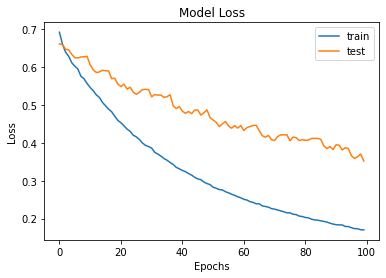

In [78]:
plt.plot(History2.history['loss'])
plt.plot(History2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

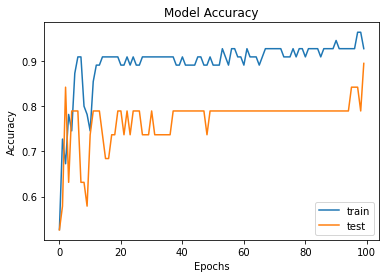

In [79]:
plt.plot(History2.history['accuracy'])
plt.plot(History2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [80]:
pred2=model2.predict(x_test)
pred_digits2=np.round(abs(pred2)).astype(int)
print(pred_digits2)

[[0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [81]:
model2.save("model/BCDVGG16.h5")

In [82]:
_, acc2 = model2.evaluate(x_test, y_test)
print("Accuracy = ", (acc2 * 100.0), "%")

1/1 [==============================] - 3s 3s/step - loss: 0.3522 - accuracy: 0.8947
Accuracy =  89.47368264198303 %


In [83]:
print(classification_report(y_test,pred_digits2))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.80      0.89        10

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



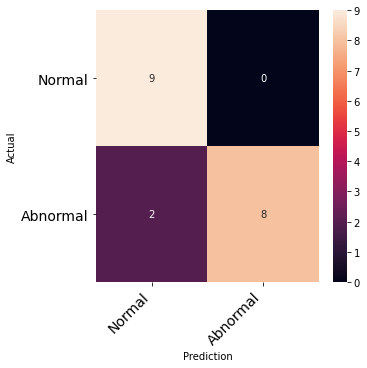

In [84]:
cm = confusion_matrix(y_test,pred_digits2)
print_confusion_matrix(cm,["Normal","Abnormal"])

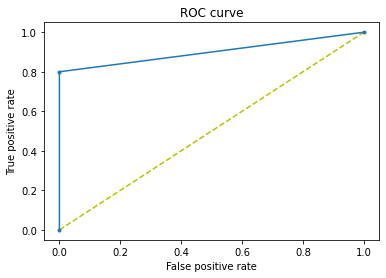

In [85]:
roc2 = pred_digits2.ravel()
fpr, tpr, thresholds = roc_curve(y_test, roc2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [86]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [87]:
auc_value2 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value2)

Area under curve, AUC =  0.9


In [88]:
## inception_v3 

In [89]:
def create_model3():
    base_model=inception_v3.InceptionV3(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)  #softmax
    model3=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model3

In [90]:
batch_size=9
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr3= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [91]:
model3 = create_model3()

model3.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [92]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 111, 111, 32) 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [93]:
History3 = model3.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/100
7/7 [==============================] - 9s 647ms/step - loss: 0.7993 - accuracy: 0.5636 - val_loss: 0.8237 - val_accuracy: 0.4737
Epoch 2/100
7/7 [==============================] - 3s 418ms/step - loss: 0.4246 - accuracy: 0.8364 - val_loss: 0.7450 - val_accuracy: 0.5263
Epoch 3/100
7/7 [==============================] - 3s 439ms/step - loss: 0.3381 - accuracy: 0.8364 - val_loss: 0.5446 - val_accuracy: 0.6842
Epoch 4/100
7/7 [==============================] - 3s 428ms/step - loss: 0.2389 - accuracy: 0.9455 - val_loss: 0.4120 - val_accuracy: 0.7368
Epoch 5/100
7/7 [==============================] - 3s 433ms/step - loss: 0.1943 - accuracy: 0.9636 - val_loss: 0.3101 - val_accuracy: 0.8421
Epoch 6/100
7/7 [==============================] - 3s 463ms/step - loss: 0.1503 - accuracy: 1.0000 - val_loss: 0.2425 - val_accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 4s 536ms/step - loss: 0.1446 - accuracy: 1.0000 - val_loss: 0.3204 - val_accuracy: 0.7895
Epoch 8/100
7

7/7 [==============================] - 4s 557ms/step - loss: 1.3302e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 59/100
7/7 [==============================] - 4s 524ms/step - loss: 1.2557e-05 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 60/100
7/7 [==============================] - 4s 527ms/step - loss: 7.8987e-06 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 61/100
7/7 [==============================] - 4s 531ms/step - loss: 7.0704e-06 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 62/100
7/7 [==============================] - 4s 532ms/step - loss: 6.8800e-06 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 63/100
7/7 [==============================] - 4s 536ms/step - loss: 5.0930e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 64/100
7/7 [==============================] - 4s 548ms/step - loss: 6.5344e-06 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy

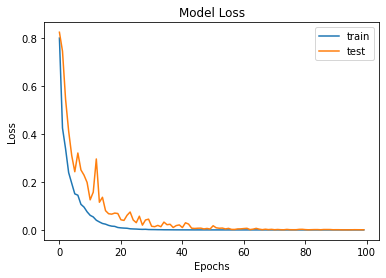

In [94]:
plt.plot(History3.history['loss'])
plt.plot(History3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

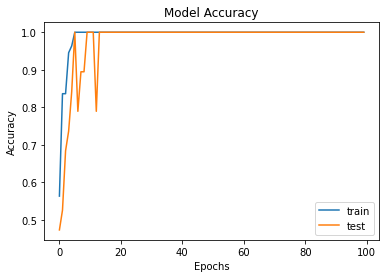

In [95]:
plt.plot(History3.history['accuracy'])
plt.plot(History3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [96]:
pred3=model3.predict(x_test)
pred_digits3= np.round(abs(pred3)).astype(int)
print(pred_digits3)

[[0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]]


In [97]:
model3.save("model/BCDinceptionV3.h5")

In [98]:
_, acc3 = model3.evaluate(x_test, y_test)
print("Accuracy = ", (acc3 * 100.0), "%")

1/1 [==============================] - 1s 622ms/step - loss: 6.0112e-04 - accuracy: 1.0000
Accuracy =  100.0 %


In [99]:
print(classification_report(y_test,pred_digits3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        10

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



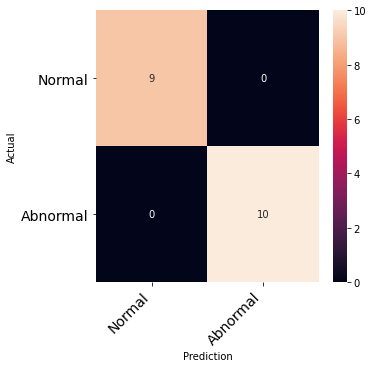

In [100]:
cm = confusion_matrix(y_test,pred_digits3)
print_confusion_matrix(cm,["Normal","Abnormal"])

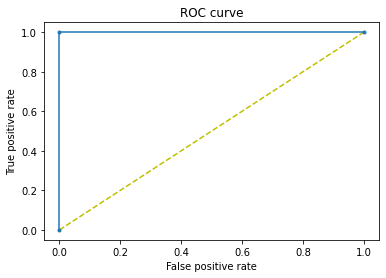

In [101]:
roc3 = pred_digits3.ravel()

fpr, tpr, thresholds = roc_curve(y_test, roc3)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [102]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [103]:
auc_value3 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value3)

Area under curve, AUC =  1.0


In [104]:
i=0
prop_class3=[]
mis_class3=[]

for i in range(len(y_test)):
    if(y_test[i])==pred_digits3[i]:
        prop_class3.append(i)

i=0
for i in range(len(y_test)):
    if(not (y_test[i])==pred_digits3[i]):
        mis_class3.append(i)
        
print(len(prop_class3))
print(len(mis_class3))

19
0


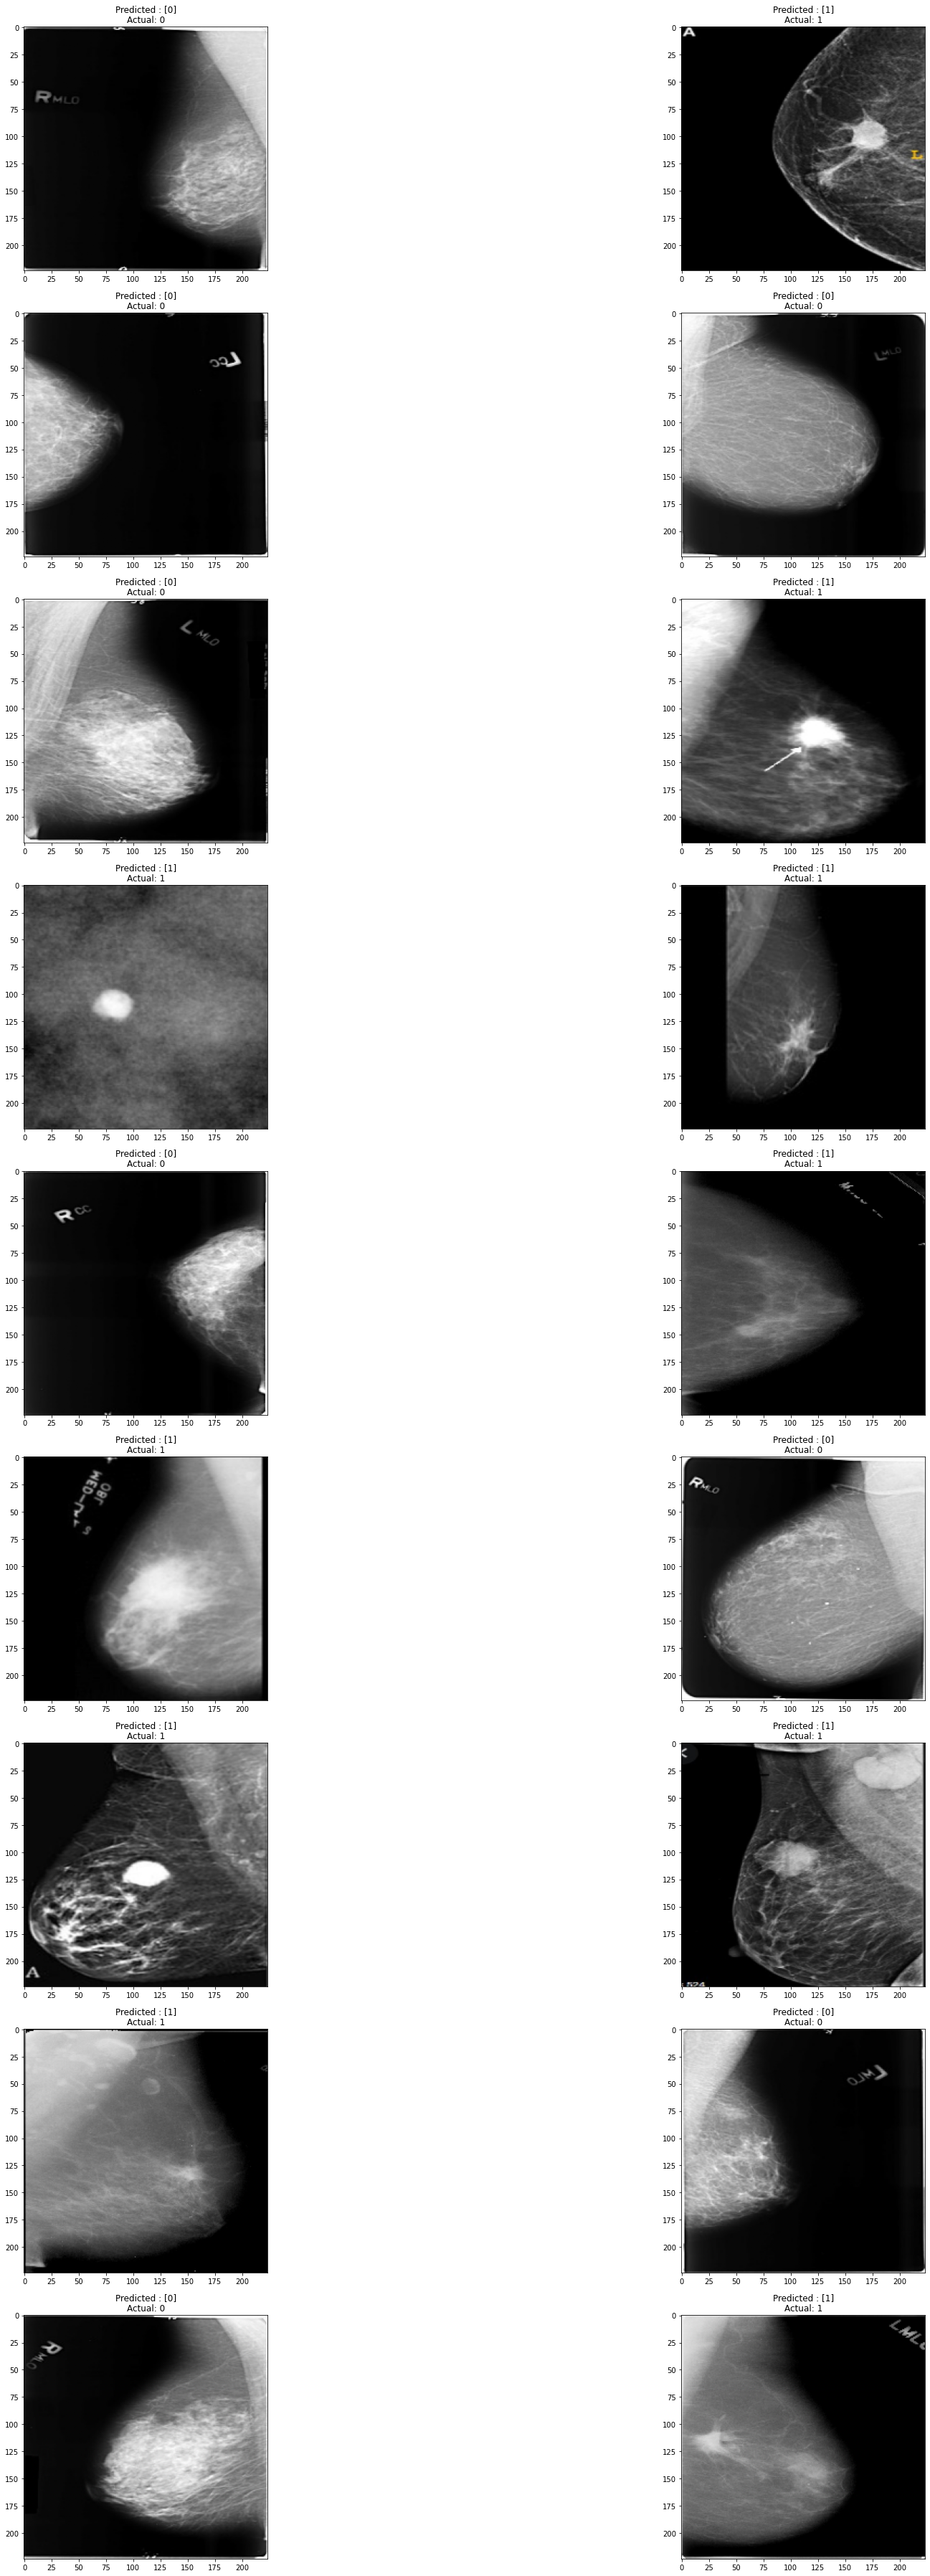

In [105]:
if len(prop_class3)>0:
    count=0
    fig,ax=plt.subplots(9,2)
    fig.set_size_inches(50,50)
    for i in range (9):
        for j in range (2):
            ax[i,j].imshow(x_test[prop_class3[count]])
            ax[i,j].set_title("Predicted : "+str(pred_digits3[prop_class3[count]])+"\n"+"Actual: "+ str(y_test[prop_class3[count]]))
            plt.tight_layout()
            count+=1
else:
    print("every images are miss-classify...")

In [106]:
if len(mis_class3)>0:
    count=0
    fig,ax=plt.subplots(4,2)
    fig.set_size_inches(15,15)
    for i in range (4):
        for j in range (2):
            ax[i,j].imshow(x_test[mis_class3[count]])
            ax[i,j].set_title("Predicted : "+str([pred_digits3[mis_class3[count]]])+"\n"+"Actual: "+str(np.argmax([y_test[mis_class3[count]]])))
            plt.tight_layout()
            count+=1
else:
    print("every images are perfectly classify...")

every images are perfectly classify...


In [107]:
## CNN with SVM 

In [108]:
from tensorflow.keras.regularizers import l2

In [109]:
def create_model4():
    model4 = Sequential()
    model4.add(Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))
    model4.add(MaxPooling2D(pool_size=2, strides=2))

    model4.add(Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
    model4.add(MaxPooling2D(pool_size=2, strides=2))

    model4.add(Dense(units=128, activation='relu'))

    model4.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
                 ='linear'))
    
    model4.add(Flatten())
    return model4

In [110]:
batch_size=7
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr4= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [111]:
model4 = create_model4()

model4.compile(optimizer = 'adam', 
            loss = 'hinge', 
            metrics = ['accuracy'])

In [112]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dense_9 (Dense)              (None, 8, 8, 128)         4224      
_________________________________________________________________
dense_10 (Dense)             (None, 8, 8, 1)           129       
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)               

In [113]:
History4 = model4.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/100
8/8 [==============================] - 2s 92ms/step - loss: 1.0410 - accuracy: 0.0182 - val_loss: 1.0146 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 0s 63ms/step - loss: 1.0153 - accuracy: 0.0000e+00 - val_loss: 1.0171 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 0s 59ms/step - loss: 1.0016 - accuracy: 0.0182 - val_loss: 1.0169 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 0s 57ms/step - loss: 0.9938 - accuracy: 0.0000e+00 - val_loss: 1.0202 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 0s 63ms/step - loss: 0.9553 - accuracy: 0.0000e+00 - val_loss: 1.0244 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 1s 64ms/step - loss: 0.9556 - accuracy: 0.0000e+00 - val_loss: 1.0401 - val_accuracy: 0.0000e+00
Epoch 7/100
8/8 [==============================] - 1s 68ms/step - loss: 0.9383 - accuracy: 0.0000e+00 - val_loss: 1.0141

Epoch 49/100
8/8 [==============================] - 1s 74ms/step - loss: 0.5403 - accuracy: 0.0000e+00 - val_loss: 0.7442 - val_accuracy: 0.0000e+00
Epoch 50/100
8/8 [==============================] - 1s 67ms/step - loss: 0.5267 - accuracy: 0.0000e+00 - val_loss: 0.7241 - val_accuracy: 0.0000e+00
Epoch 51/100
8/8 [==============================] - 1s 68ms/step - loss: 0.5441 - accuracy: 0.0000e+00 - val_loss: 0.7261 - val_accuracy: 0.0000e+00
Epoch 52/100
8/8 [==============================] - 1s 70ms/step - loss: 0.5365 - accuracy: 0.0000e+00 - val_loss: 0.7429 - val_accuracy: 0.0000e+00
Epoch 53/100
8/8 [==============================] - 1s 64ms/step - loss: 0.5310 - accuracy: 0.0000e+00 - val_loss: 0.7261 - val_accuracy: 0.0000e+00
Epoch 54/100
8/8 [==============================] - 1s 71ms/step - loss: 0.5238 - accuracy: 0.0000e+00 - val_loss: 0.7242 - val_accuracy: 0.0000e+00
Epoch 55/100
8/8 [==============================] - 1s 68ms/step - loss: 0.5407 - accuracy: 0.0000e+00 - v

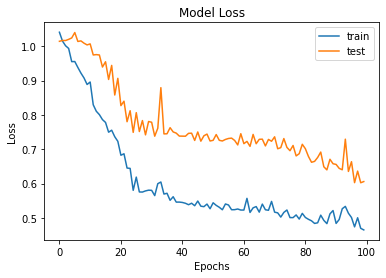

In [114]:
plt.plot(History4.history['loss'])
plt.plot(History4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

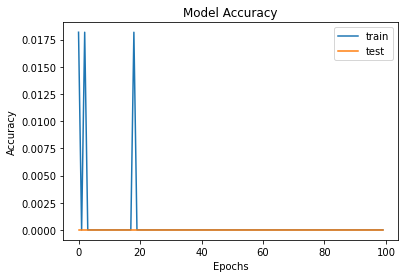

In [115]:
plt.plot(History4.history['accuracy'])
plt.plot(History4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [116]:
model4.save("model/BCDSVMCNN.h5")

In [117]:
pred4=model4.predict(x_test)
pred_digits4= np.round(abs(pred4)).astype(int)
print(pred_digits4)

[[3 2 2 ... 1 1 1]
 [0 1 0 ... 2 2 2]
 [3 1 1 ... 2 2 3]
 ...
 [1 1 1 ... 1 1 3]
 [2 1 1 ... 1 1 2]
 [3 1 1 ... 2 2 3]]


In [118]:
_, acc4 = model4.evaluate(x_test, y_test)
print("Accuracy = ", (acc4 * 100.0), "%")

1/1 [==============================] - 0s 63ms/step - loss: 0.6059 - accuracy: 0.0000e+00
Accuracy =  0.0 %


In [119]:
# Compare Acuuracy

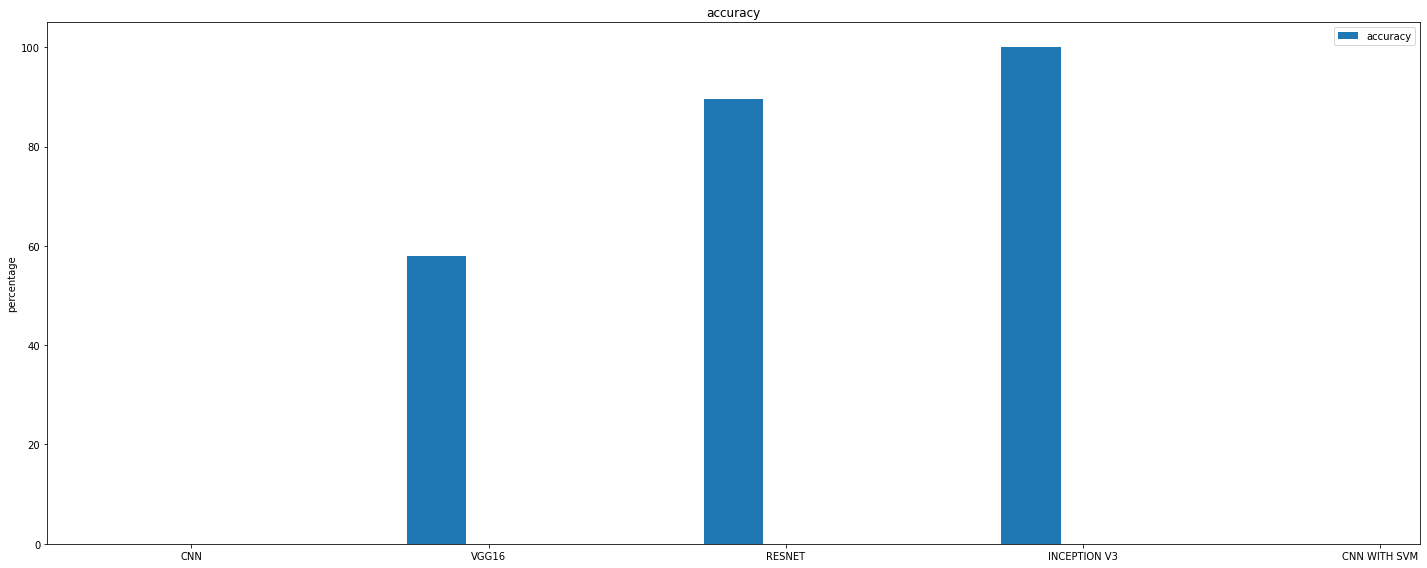

In [120]:
accuracy = [acc*100,acc1*100,acc2*100,acc3*100,acc4*100]

labels = ["CNN","VGG16","RESNET","INCEPTION V3","CNN WITH SVM"]

x=np.arange(len(labels))
width= 0.35

fig , ax = plt.subplots(figsize=(20, 8))

rect1 = ax.bar(x - width/2 ,accuracy, label="accuracy", width=.2)

ax.set_ylabel('percentage')
ax.set_title('accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.tight_layout()

plt.legend()
plt.show()

In [121]:
#====================================END==========================================#